# 1. Checking correlation of travel season vs. hotel_cluster

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
# Load data (falls noch nicht im Speicher)
df3 = pd.read_csv("data/onlybookings.csv", low_memory=False)

# Parse check-in date
df3["srch_ci"] = pd.to_datetime(df3["srch_ci"], errors="coerce")

# Function to map month -> season
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df3["season"] = df3["srch_ci"].dt.month.map(month_to_season)

In [6]:
# Count bookings per (season, hotel_cluster)
season_cluster_counts = (
    df3.groupby(["season", "hotel_cluster"])
               .size()
               .reset_index(name="count")
)

# Normalize within each season to get relative preference
season_cluster_counts["share"] = season_cluster_counts.groupby("season")["count"].transform(
    lambda x: x / x.sum()
)

# Top 5 clusters per season
top5_per_season = (
    season_cluster_counts.sort_values(["season", "share"], ascending=[True, False])
                        .groupby("season")
                        .head(5)
)
print(top5_per_season)


     season  hotel_cluster  count     share
91   Autumn             91  11588  0.041442
48   Autumn             48   7949  0.028428
42   Autumn             42   6966  0.024912
28   Autumn             28   6091  0.021783
59   Autumn             59   5854  0.020935
191  Spring             91   8753  0.040242
148  Spring             48   6618  0.030426
142  Spring             42   5109  0.023489
159  Spring             59   4888  0.022473
128  Spring             28   4435  0.020390
291  Summer             91  11887  0.041460
248  Summer             48   8394  0.029277
242  Summer             42   7007  0.024439
228  Summer             28   6296  0.021960
259  Summer             59   5751  0.020059
391  Winter             91   8157  0.037736
348  Winter             48   5947  0.027512
359  Winter             59   5577  0.025800
342  Winter             42   5417  0.025060
395  Winter             95   4637  0.021452


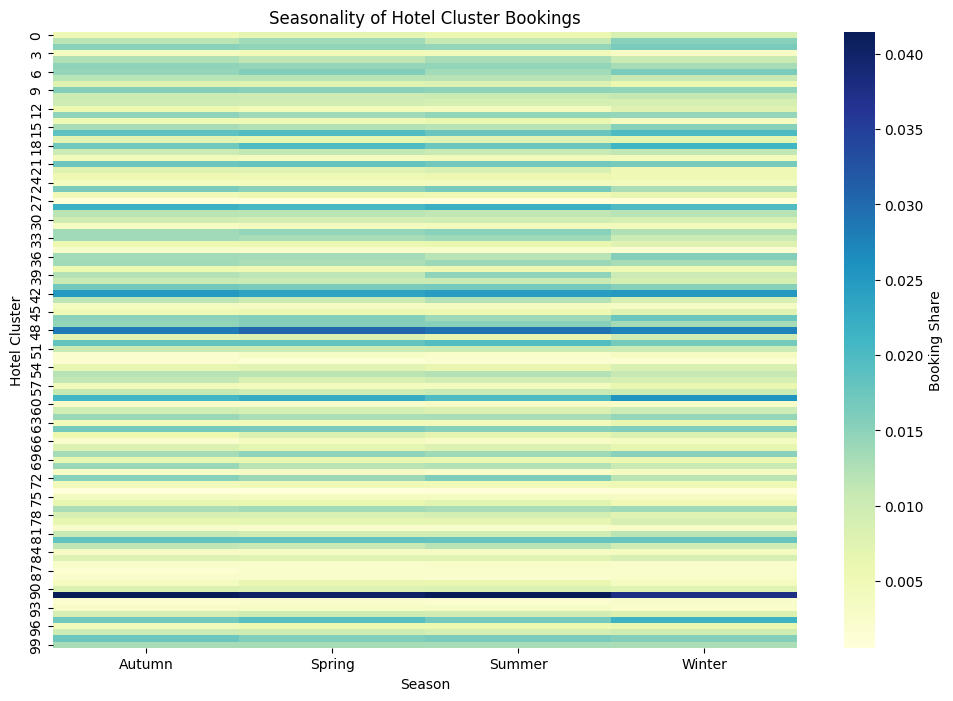

In [7]:
# Pivot table for heatmap
pivot = season_cluster_counts.pivot(index="hotel_cluster", columns="season", values="share").fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'Booking Share'})
plt.title("Seasonality of Hotel Cluster Bookings")
plt.xlabel("Season")
plt.ylabel("Hotel Cluster")
plt.show()

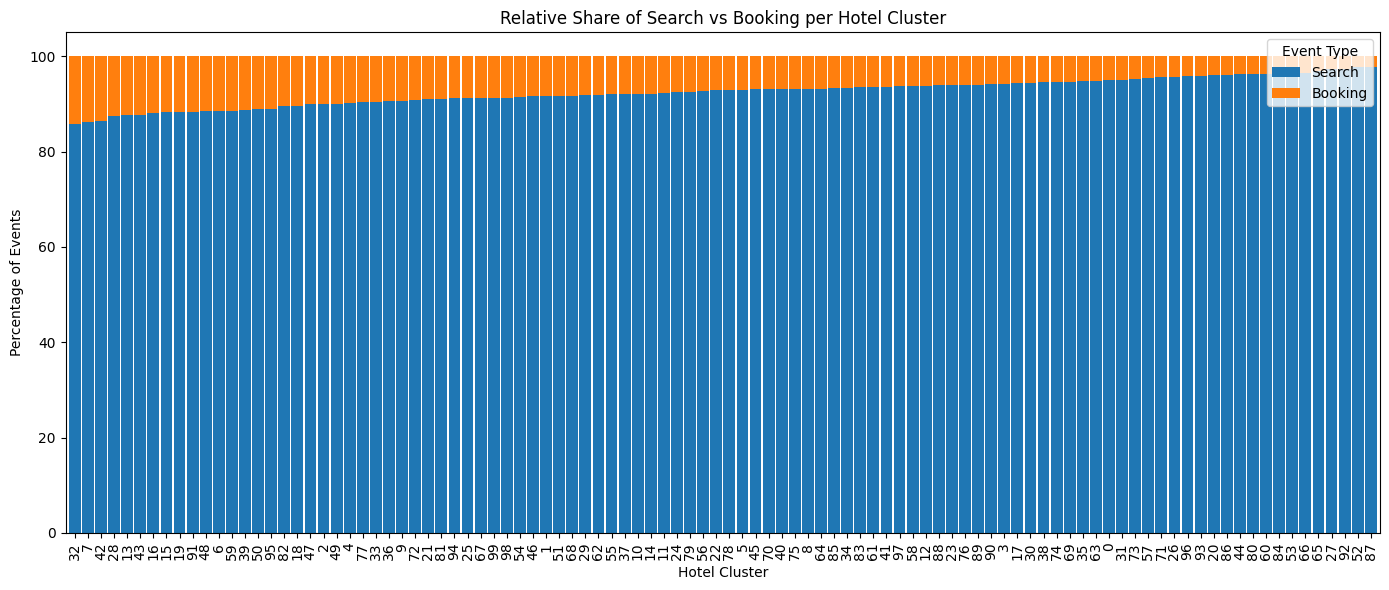

In [ ]:
# Load sample (dataframe with ALL events, not just bookings)
df4 = pd.read_csv("data/train_sample_1M.csv", low_memory=False)

# Count events per cluster, split by booking vs search
cluster_counts = df4.groupby(["hotel_cluster", "is_booking"]).size().unstack(fill_value=0)

# Rename columns
cluster_counts.columns = ["Search", "Booking"]

# Convert to percentage share of total events
cluster_perc = cluster_counts.div(cluster_counts.sum(axis=1), axis=0) * 100

# Sort by Booking share (for readability)
cluster_perc = cluster_perc.sort_values("Booking", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(14,6))
cluster_perc.plot(kind="bar", stacked=True, ax=ax, width=0.9)

ax.set_title("Relative Share of Search vs Booking per Hotel Cluster")
ax.set_xlabel("Hotel Cluster")
ax.set_ylabel("Percentage of Events")
ax.legend(title="Event Type", loc="upper right")

plt.tight_layout()
plt.show()

In [10]:
# checking correlation between season and hotel cluster 
pivot = df3.pivot_table(
    index="hotel_cluster", 
    columns="season", 
    values="srch_ci",    # irgendein Feld, zählt einfach die Events
    aggfunc="count"
).fillna(0)


In [11]:
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

In [12]:
corr_matrix = pivot_norm.corr(method="pearson")  # oder spearman
print(corr_matrix)

season    Autumn    Spring    Summer    Winter
season                                        
Autumn  1.000000 -0.585975  0.142559 -0.517881
Spring -0.585975  1.000000 -0.048332 -0.054657
Summer  0.142559 -0.048332  1.000000 -0.817298
Winter -0.517881 -0.054657 -0.817298  1.000000


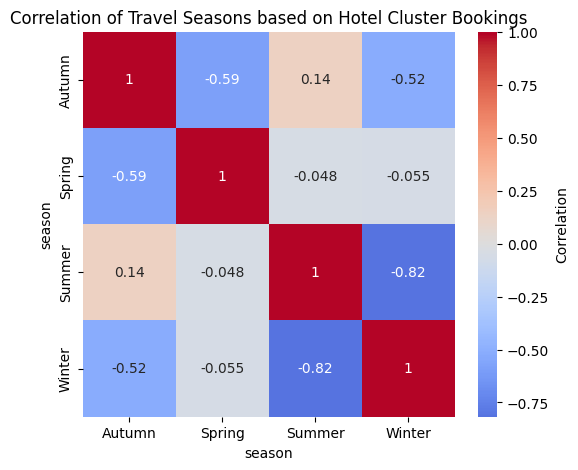

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, cbar_kws={"label": "Correlation"})
plt.title("Correlation of Travel Seasons based on Hotel Cluster Bookings")
plt.show()

# 2. Checking correlation of origin distance with travel season and hotel clusters

In [14]:
# ---------- Prep: parse dates & build 'season' ----------
# Expect 'srch_ci' to be present. If not, adapt to your column.
df3 = df3.copy()
df3["srch_ci"] = pd.to_datetime(df3["srch_ci"], errors="coerce")

def month_to_season(m):
    if m in (12, 1, 2):  return "Winter"
    if m in (3, 4, 5):   return "Spring"
    if m in (6, 7, 8):   return "Summer"
    return "Autumn"

df3["season"] = df3["srch_ci"].dt.month.map(month_to_season)

# ---------- Clean numeric distance ----------
# Coerce to numeric and handle obvious invalids (e.g., negative distances).
df3["orig_destination_distance"] = pd.to_numeric(df3["orig_destination_distance"], errors="coerce")
df3.loc[df3["orig_destination_distance"] < 0, "orig_destination_distance"] = np.nan

# Optional: clip outliers to reduce skew for plotting (keep raw for modeling if you like)
q01, q99 = df3["orig_destination_distance"].quantile([0.01, 0.99])
df3["distance_clipped"] = df3["orig_destination_distance"].clip(lower=q01, upper=q99)

# ---------- Imputation strategy (simple, robust) ----------
# 1) start with global median fallback
global_med = df3["orig_destination_distance"].median()

# 2) group-wise median by (season, hotel_cluster)
grp_median = (
    df3.groupby(["season", "hotel_cluster"])["orig_destination_distance"]
       .median()
)

# Helper to look up group median with fallback
def impute_distance(row):
    if not np.isnan(row["orig_destination_distance"]):
        return row["orig_destination_distance"]
    key = (row["season"], row["hotel_cluster"])
    if key in grp_median:
        return grp_median.loc[key]
    return global_med

df3["distance_was_missing"] = df3["orig_destination_distance"].isna().astype(int)
df3["distance_imputed"] = df3.apply(impute_distance, axis=1)

# Optional: log-transform for nicer distributions in plots/models
df3["distance_imputed_log"] = np.log1p(df3["distance_imputed"])


         count    median         mean          std     min         max
season                                                                
Autumn  279621  940.8182  1817.925770  2049.785926  0.0056  11874.4465
Spring  217510  984.7795  1772.692242  1979.888979  0.0056  12052.0210
Summer  286708  885.4881  1726.832812  1939.161941  0.0056  11761.4105
Winter  216162  971.1832  1783.980399  2047.514752  0.0056  11867.8696


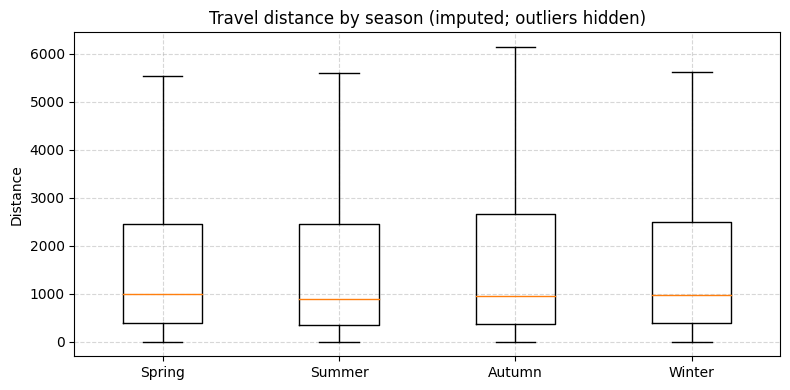

In [16]:
# Summary stats by season
season_stats = (
    df3.groupby("season")["distance_imputed"]
       .agg(["count", "median", "mean", "std", "min", "max"])
       .sort_index()
)
print(season_stats)

# Boxplot: distance by season (clipped for readability)
fig, ax = plt.subplots(figsize=(8, 4))
to_plot = [df3.loc[df3["season"]==s, "distance_imputed"] for s in ["Spring","Summer","Autumn","Winter"]]
ax.boxplot(to_plot, labels=["Spring","Summer","Autumn","Winter"], showfliers=False)
ax.set_title("Travel distance by season (imputed; outliers hidden)")
ax.set_ylabel("Distance")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


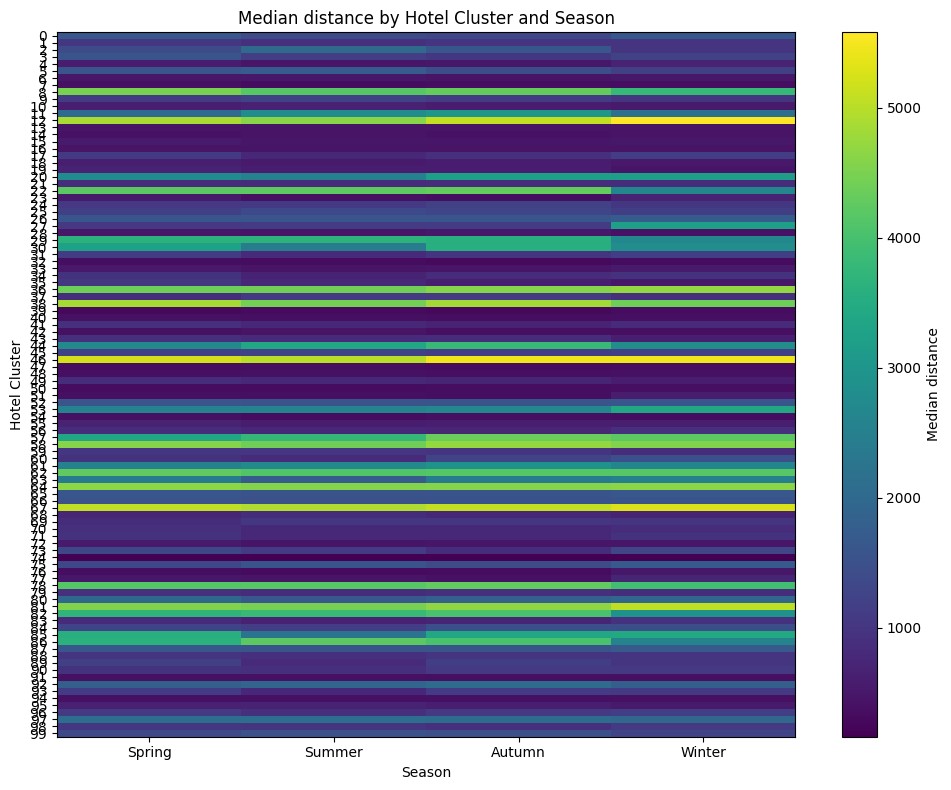

In [17]:
# Keep only clusters with sufficient bookings to avoid noise
cluster_sizes = df3["hotel_cluster"].value_counts()
keep_clusters = cluster_sizes[cluster_sizes >= 200].index
df_small = df3[df3["hotel_cluster"].isin(keep_clusters)]

# Median distance per (cluster, season)
pivot_med = (
    df_small.groupby(["hotel_cluster", "season"])["distance_imputed"]
            .median()
            .unstack("season")
            .reindex(columns=["Spring","Summer","Autumn","Winter"])
)

# Normalize rows (optional) to highlight seasonal preference as relative pattern
# pivot_med_norm = pivot_med.div(pivot_med.mean(axis=1), axis=0)

# Simple matplotlib heatmap (no seaborn)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(pivot_med.values, aspect="auto")

# X/Y ticks
ax.set_xticks(range(pivot_med.shape[1]))
ax.set_xticklabels(pivot_med.columns)
ax.set_yticks(range(pivot_med.shape[0]))
ax.set_yticklabels(pivot_med.index)

ax.set_title("Median distance by Hotel Cluster and Season")
ax.set_xlabel("Season")
ax.set_ylabel("Hotel Cluster")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Median distance")

plt.tight_layout()
plt.show()


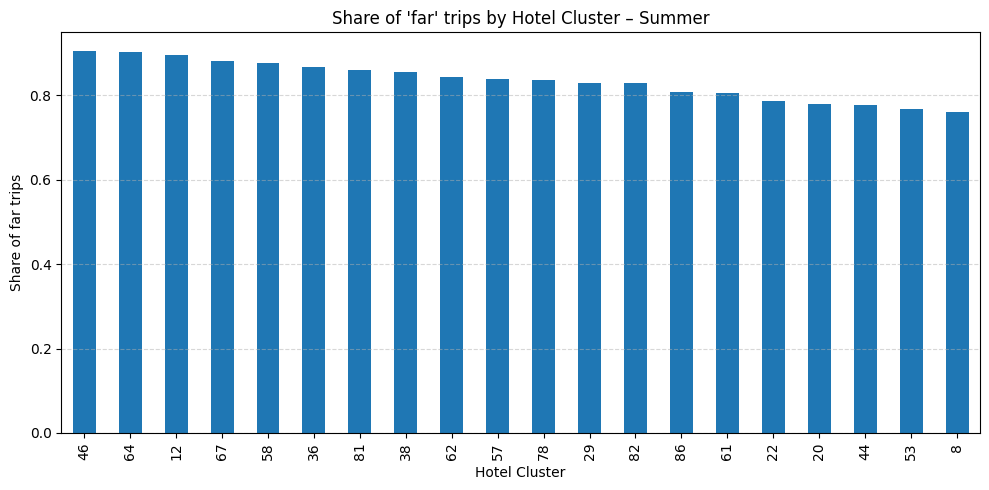

In [18]:
# Create distance buckets using global quantiles
df3["distance_bucket"] = pd.qcut(df3["distance_imputed"], q=4, labels=["Q1 (near)","Q2","Q3","Q4 (far)"])

# Share of 'far' trips per (season, cluster)
far_share = (
    df3.assign(is_far = (df3["distance_bucket"]=="Q4 (far)").astype(int))
       .groupby(["season","hotel_cluster"])["is_far"]
       .mean()
       .unstack("season")
       .reindex(columns=["Spring","Summer","Autumn","Winter"])
)

# Plot a single season ranking (e.g., Summer) for top 20 clusters by 'far' share
season_choice = "Summer"
top20 = far_share[season_choice].sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10,5))
top20.plot(kind="bar", ax=ax)
ax.set_title(f"Share of 'far' trips by Hotel Cluster – {season_choice}")
ax.set_ylabel("Share of far trips")
ax.set_xlabel("Hotel Cluster")
ax.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [20]:
# --- prep: dummy encoding for season ---
season_dummies = pd.get_dummies(df3["season"], drop_first=False)

# join with distance
df_corr = pd.concat([season_dummies, df3["orig_destination_distance"]], axis=1).dropna()

# Pearson correlation
corr = df_corr.corr(method="pearson")["orig_destination_distance"].drop("orig_destination_distance")
print("Pearson correlation of distance with each season:")
print(corr)

# Spearman correlation (rank-based, robust to skew)
corr_spear = df_corr.corr(method="spearman")["orig_destination_distance"].drop("orig_destination_distance")
print("\nSpearman correlation of distance with each season:")
print(corr_spear)

Pearson correlation of distance with each season:
Autumn    0.007224
Spring    0.000427
Summer   -0.009955
Winter    0.002716
Name: orig_destination_distance, dtype: float64

Spearman correlation of distance with each season:
Autumn   -0.004484
Spring    0.007561
Summer   -0.001945
Winter   -0.000584
Name: orig_destination_distance, dtype: float64


# 3. Analyse event count per session vs. booking/ non-booking

Mean cnt (search): 1.5237075661289448
Median cnt (search): 1.0
Mean cnt (booking): 1.0148521082441788
Median cnt (booking): 1.0


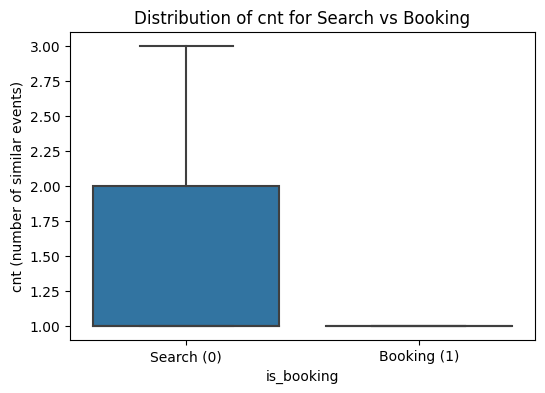

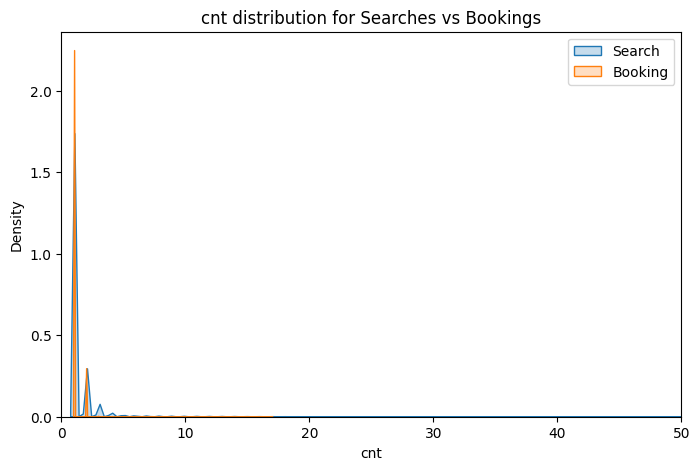

In [21]:
# Split data
searches = df4[df4["is_booking"] == 0]["cnt"]
bookings = df4[df4["is_booking"] == 1]["cnt"]

# --- 1) Summary stats ---
print("Mean cnt (search):", searches.mean())
print("Median cnt (search):", searches.median())
print("Mean cnt (booking):", bookings.mean())
print("Median cnt (booking):", bookings.median())

# --- 2) Boxplot comparison ---
plt.figure(figsize=(6,4))
sns.boxplot(x="is_booking", y="cnt", data=df4, showfliers=False)
plt.xticks([0,1], ["Search (0)","Booking (1)"])
plt.title("Distribution of cnt for Search vs Booking")
plt.ylabel("cnt (number of similar events)")
plt.show()

# --- 3) Histogram / KDE ---
plt.figure(figsize=(8,5))
sns.kdeplot(searches, label="Search", shade=True)
sns.kdeplot(bookings, label="Booking", shade=True)
plt.xlim(0,50)  # limit for readability (long tail clipped)
plt.title("cnt distribution for Searches vs Bookings")
plt.xlabel("cnt")
plt.ylabel("Density")
plt.legend()
plt.show()

In [23]:
# Average cnt per cluster (overall)
cluster_cnt_stats = (
    df4.groupby("hotel_cluster")["cnt"]
       .agg(["count","mean","median"])
       .sort_values("mean")
)
print(cluster_cnt_stats.head(10))   # lowest cnt clusters
print(cluster_cnt_stats.tail(10))   # highest cnt clusters

               count      mean  median
hotel_cluster                         
53              3585  1.316318     1.0
23              6879  1.322721     1.0
76              8523  1.335797     1.0
93              5647  1.335931     1.0
60              5790  1.339206     1.0
20              8020  1.357357     1.0
40             11448  1.357530     1.0
39              9209  1.363775     1.0
14              5155  1.363919     1.0
94              7836  1.364344     1.0
               count      mean  median
hotel_cluster                         
63              7988  1.638458     1.0
79              7549  1.649622     1.0
1              12076  1.656095     1.0
27              2819  1.672934     1.0
24              4345  1.675949     1.0
26             10147  1.681876     1.0
45              6310  1.730111     1.0
52              8945  1.740861     1.0
65             17893  1.775331     1.0
66              7229  1.864850     1.0


In [24]:
cluster_cnt_split = (
    df4.groupby(["hotel_cluster","is_booking"])["cnt"]
       .mean()
       .unstack()
       .rename(columns={0:"mean_cnt_search", 1:"mean_cnt_booking"})
)
print(cluster_cnt_split.head(15))


is_booking     mean_cnt_search  mean_cnt_booking
hotel_cluster                                   
0                     1.660617          1.009804
1                     1.714040          1.019841
2                     1.551598          1.017271
3                     1.462087          1.031073
4                     1.498061          1.012222
5                     1.458631          1.015584
6                     1.499724          1.019591
7                     1.504894          1.011702
8                     1.504906          1.011745
9                     1.580538          1.020117
10                    1.477841          1.010502
11                    1.513133          1.008253
12                    1.440241          1.021127
13                    1.521073          1.014453
14                    1.393601          1.014851


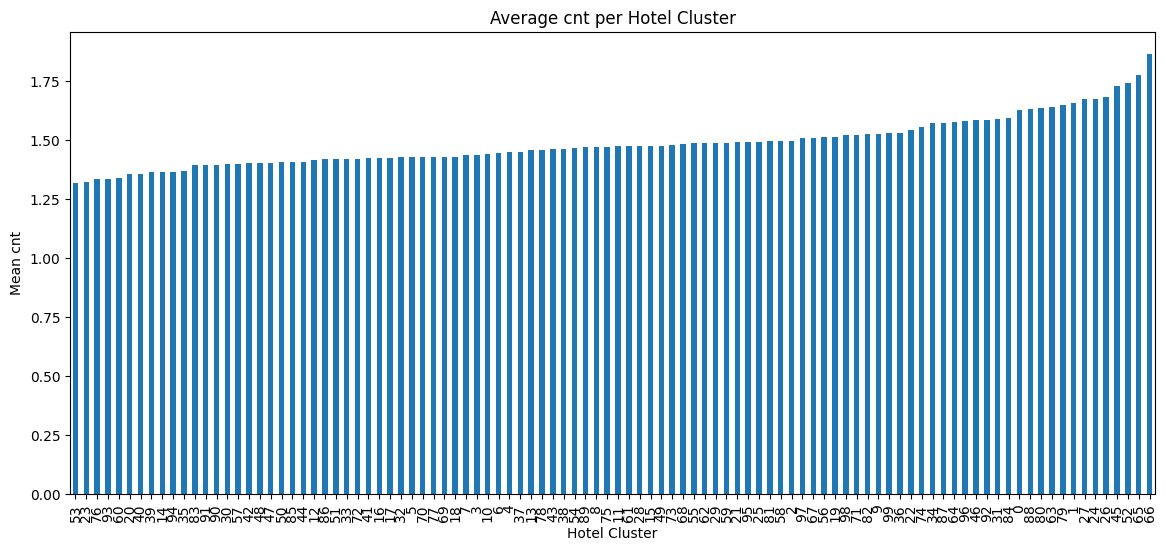

In [27]:
mean_cnt_per_cluster = df4.groupby("hotel_cluster")["cnt"].mean().sort_values()

plt.figure(figsize=(14,6))
mean_cnt_per_cluster.plot(kind="bar")
plt.title("Average cnt per Hotel Cluster")
plt.xlabel("Hotel Cluster")
plt.ylabel("Mean cnt")
plt.show()

# 4. Analyzing Hotel Markets

In [28]:
# Top 10 hotel markets by number of bookings
top10_markets = df3["hotel_market"].value_counts().head(10)
top10_markets

hotel_market
628     43127
675     31785
365     23243
19      19000
1230    17103
637     15311
701     15083
682     14859
191     12855
27      11555
Name: count, dtype: int64

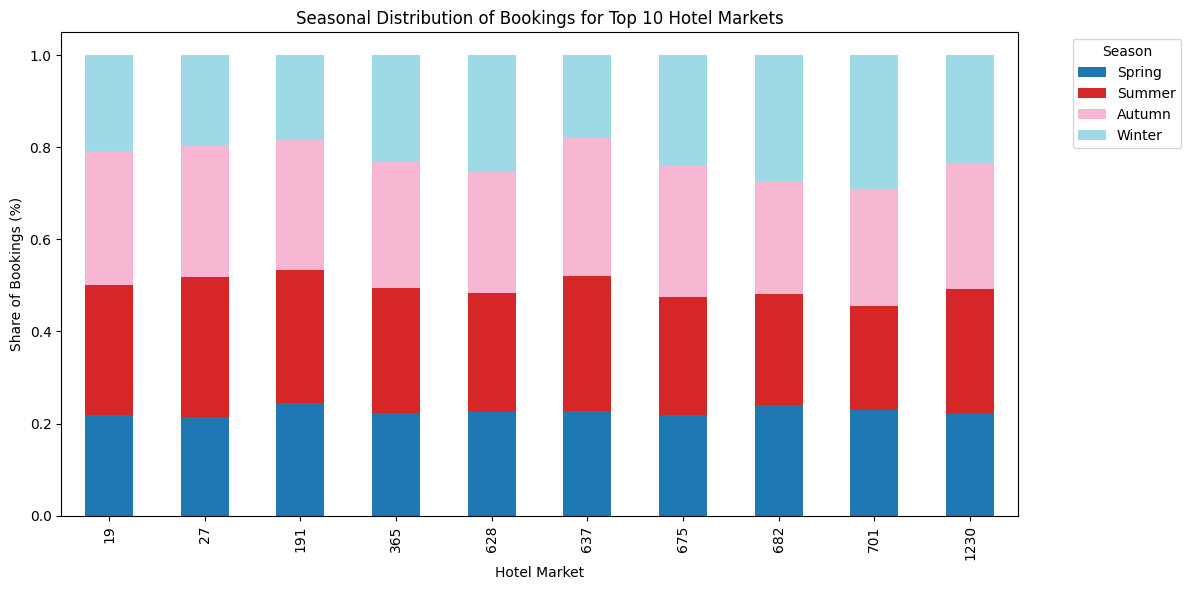

In [29]:
# Filter to top 10 hotel markets
top_markets = top10_markets.index.tolist()
df_top = df3[df3["hotel_market"].isin(top_markets)]

# Count bookings per market and season
market_season_counts = (
    df_top.groupby(["hotel_market", "season"])
          .size()
          .reset_index(name="count")
)

# Normalize within each market for percentages
market_season_counts["share"] = market_season_counts.groupby("hotel_market")["count"].transform(
    lambda x: x / x.sum()
)

# Pivot for plotting
pivot = market_season_counts.pivot(index="hotel_market", columns="season", values="share").fillna(0)
pivot = pivot[["Spring","Summer","Autumn","Winter"]]  # consistent order

# Plot as stacked bar chart
pivot.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.title("Seasonal Distribution of Bookings for Top 10 Hotel Markets")
plt.xlabel("Hotel Market")
plt.ylabel("Share of Bookings (%)")
plt.legend(title="Season", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5. Analyzin all features on booking vs. non-booking

In [31]:
df_train = pd.read_csv("data/train_sample_1M.csv", low_memory=False)

# Convert date columns
df_train["srch_ci"] = pd.to_datetime(df_train["srch_ci"], errors="coerce")
df_train["date_time"] = pd.to_datetime(df_train["date_time"], errors="coerce")

# Add season column
def month_to_season(m):
    if m in (12, 1, 2):  return "Winter"
    if m in (3, 4, 5):   return "Spring"
    if m in (6, 7, 8):   return "Summer"
    return "Autumn"

df_train["season"] = df_train["srch_ci"].dt.month.map(month_to_season)

# Separate numeric vs categorical
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df_train.columns if c not in numeric_cols]

# --- 1) Numeric comparison ---
numeric_summary = df_train.groupby("is_booking")[numeric_cols].agg(["mean","median","std"]).T

# --- 2) Categorical comparison (relative frequencies) ---
cat_summaries = {}
for col in categorical_cols:
    freq = (
        df_train.groupby("is_booking")[col]
                .value_counts(normalize=True)
                .rename("share")
                .reset_index()
    )
    cat_summaries[col] = freq

# numeric_summary -> DataFrame with means/medians
# cat_summaries -> dict of DataFrames per categorical col


In [33]:
from scipy.spatial.distance import jensenshannon

# ===============================
# 4) AUTO-RANKING DIFFERENCES
# ===============================

ranking_numeric = []
for col in numeric_cols:
    stats = df_train.groupby("is_booking")[col].mean()
    if len(stats) == 2:
        diff = abs(stats[1] - stats[0])
        ranking_numeric.append((col, diff))
ranking_numeric = sorted(ranking_numeric, key=lambda x: x[1], reverse=True)

print("\n=== Top numeric features by mean difference (Booking vs Search) ===\n")
for col, diff in ranking_numeric[:10]:
    print(f"{col:<30} Δmean = {diff:.3f}")


ranking_categorical = []
for col in categorical_cols:
    freq = (
        df_train.groupby("is_booking")[col]
                .value_counts(normalize=True)
                .unstack(fill_value=0)
    )
    if freq.shape[0] == 2:  # has both 0 and 1 groups
        # compute distribution difference using Jensen-Shannon divergence
        p = freq.loc[0].values
        q = freq.loc[1].values
        # normalize to avoid errors
        if p.sum() > 0 and q.sum() > 0:
            jsd = jensenshannon(p, q)
            ranking_categorical.append((col, jsd))

ranking_categorical = sorted(ranking_categorical, key=lambda x: x[1], reverse=True)

print("\n=== Top categorical features by distribution difference (Booking vs Search) ===\n")
for col, score in ranking_categorical[:10]:
    print(f"{col:<30} JSD = {score:.3f}")



=== Top numeric features by mean difference (Booking vs Search) ===

user_id                        Δmean = 3591.331
srch_destination_id            Δmean = 1039.220
orig_destination_distance      Δmean = 321.321
user_location_city             Δmean = 61.463
hotel_market                   Δmean = 22.797
user_location_region           Δmean = 4.914
hotel_cluster                  Δmean = 2.179
user_location_country          Δmean = 1.533
hotel_country                  Δmean = 1.257
is_booking                     Δmean = 1.000

=== Top categorical features by distribution difference (Booking vs Search) ===

date_time                      JSD = 0.831
srch_co                        JSD = 0.110
srch_ci                        JSD = 0.106
season                         JSD = 0.017


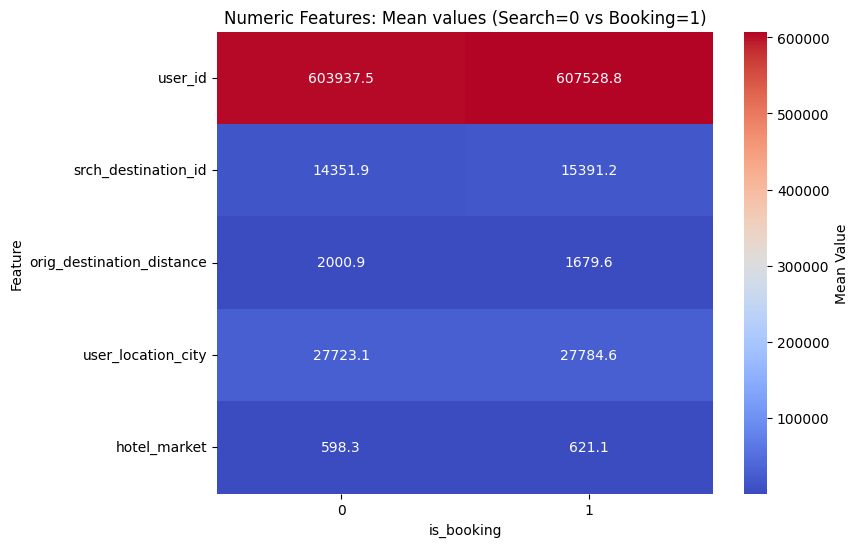

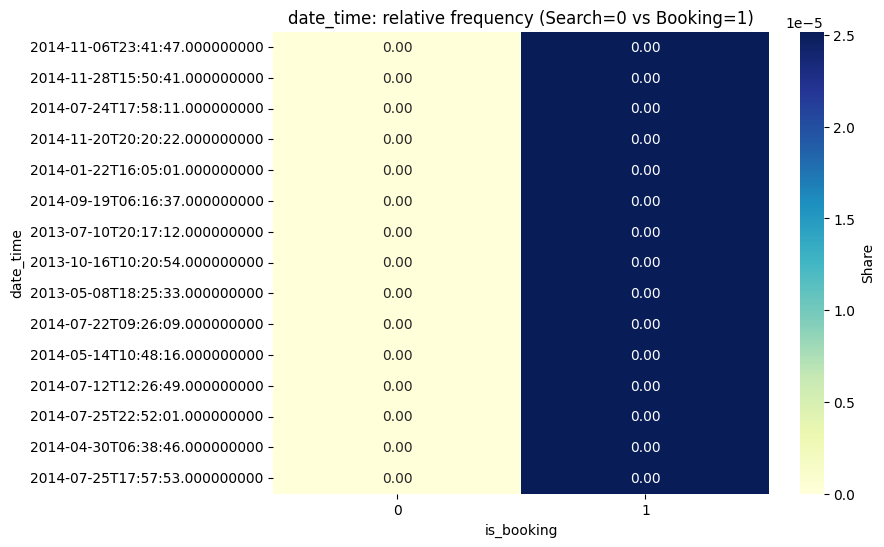

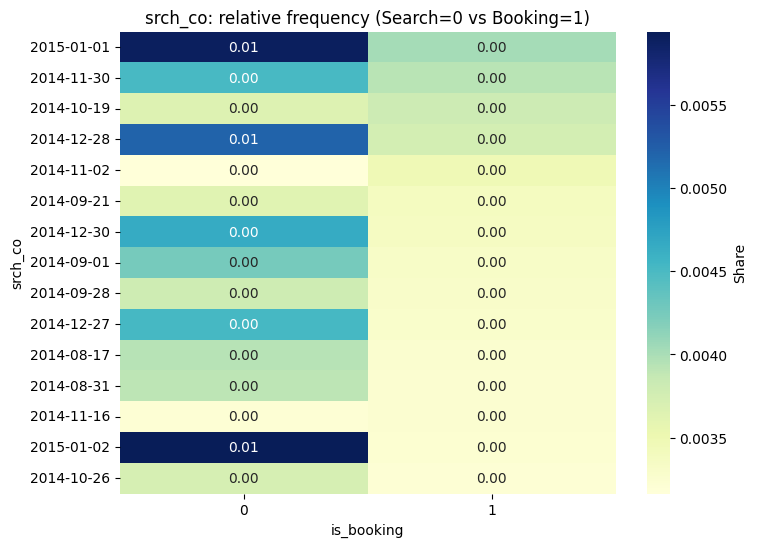

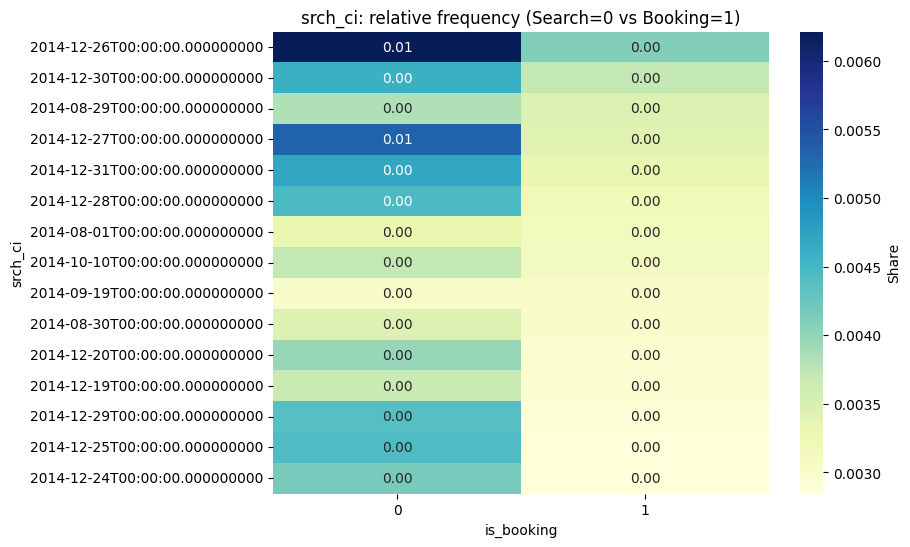

In [34]:
# ===============================
# HEATMAP FOR NUMERIC FEATURES
# ===============================
top_num_cols = [col for col, _ in ranking_numeric[:5]]  # Top 5 numeric by diff
num_means = (
    df_train.groupby("is_booking")[top_num_cols].mean()
    .T  # transpose for plotting
)

plt.figure(figsize=(8,6))
sns.heatmap(num_means, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label":"Mean Value"})
plt.title("Numeric Features: Mean values (Search=0 vs Booking=1)")
plt.ylabel("Feature")
plt.xlabel("is_booking")
plt.show()


# ===============================
# HEATMAP FOR CATEGORICAL FEATURES
# ===============================
top_cat_cols = [col for col, _ in ranking_categorical[:3]]  # Top 3 categorical

for col in top_cat_cols:
    freq = (
        df_train.groupby("is_booking")[col]
                .value_counts(normalize=True)
                .rename("share")
                .reset_index()
    )
    # Pivot for heatmap
    pivot = freq.pivot(index=col, columns="is_booking", values="share").fillna(0)
    pivot = pivot.sort_values(1, ascending=False).head(15)  # top 15 categories by booking share

    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label":"Share"})
    plt.title(f"{col}: relative frequency (Search=0 vs Booking=1)")
    plt.xlabel("is_booking")
    plt.ylabel(col)
    plt.show()


In [35]:
# Load only bookings
df = pd.read_csv("data/onlybookings.csv", low_memory=False)

# --- srch_destination_id vs cluster ---
dest_cluster_counts = (
    df.groupby(["srch_destination_id","hotel_cluster"])
      .size()
      .reset_index(name="count")
)

# For each destination: dominant cluster share
dest_totals = dest_cluster_counts.groupby("srch_destination_id")["count"].sum()
dest_cluster_counts["share"] = dest_cluster_counts["count"] / dest_cluster_counts["srch_destination_id"].map(dest_totals)

dominant_share_dest = dest_cluster_counts.groupby("srch_destination_id")["share"].max()

print("srch_destination_id -> hotel_cluster")
print(dominant_share_dest.describe())
print("Fraction of destinations with >90% same cluster:", (dominant_share_dest > 0.9).mean())


# --- hotel_id vs cluster (if present) ---
if "hotel_id" in df.columns:
    hotel_cluster_counts = (
        df.groupby(["hotel_id","hotel_cluster"])
          .size()
          .reset_index(name="count")
    )
    hotel_totals = hotel_cluster_counts.groupby("hotel_id")["count"].sum()
    hotel_cluster_counts["share"] = hotel_cluster_counts["count"] / hotel_cluster_counts["hotel_id"].map(hotel_totals)

    dominant_share_hotel = hotel_cluster_counts.groupby("hotel_id")["share"].max()

    print("\nhotel_id -> hotel_cluster")
    print(dominant_share_hotel.describe())
    print("Fraction of hotels with >90% same cluster:", (dominant_share_hotel > 0.9).mean())
else:
    print("Column hotel_id not found in dataset")


srch_destination_id -> hotel_cluster
count    25558.000000
mean         0.659502
std          0.319448
min          0.048220
25%          0.346154
50%          0.640000
75%          1.000000
max          1.000000
Name: share, dtype: float64
Fraction of destinations with >90% same cluster: 0.42002504108302685
Column hotel_id not found in dataset
